In [1]:
## Model libraries
import json
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from tcn_model_def import TCNGestureClassifier
from torch.utils.data import Dataset, DataLoader

In [2]:
# Parameters
SEQ_LEN = 10
num_features = 63
label_map = {"Idle": 0, "Aim": 1, "Fire": 2}
num_classes = len(label_map)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# --- Load NPZ dataset ---
data = np.load("all_classes_shuffled.npz", allow_pickle=True)
sequences = data["sequences"].tolist()  # list of sequences
labels = data["labels"].tolist()        # corresponding labels

In [4]:
# --- Train/validation split ---
train_idx, val_idx = train_test_split(
    list(range(len(sequences))),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_dataset = [sequences[i] for i in train_idx]
train_labels = [labels[i] for i in train_idx]

val_dataset = [sequences[i] for i in val_idx]
val_labels = [labels[i] for i in val_idx]

print("Train counts:", Counter(train_labels))
print("Val counts:", Counter(val_labels))

Train counts: Counter({'Idle': 927, 'Fire': 927, 'Aim': 927})
Val counts: Counter({'Idle': 232, 'Fire': 232, 'Aim': 232})


In [5]:
# --- Dataset & DataLoader ---
class GestureDataset(Dataset):
    def __init__(self, sequences, labels, label_map):
        """
        sequences: list of sequences, each sequence is [frame1, frame2, ...]
        labels: list of labels corresponding to sequences
        label_map: dict mapping label names to integers
        """
        self.sequences = sequences
        self.labels = labels
        self.label_map = label_map

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        landmarks = np.array(self.sequences[idx], dtype=np.float32)
        label = self.label_map[self.labels[idx]]
        return torch.from_numpy(landmarks), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    X = torch.stack([item[0] for item in batch])
    y = torch.tensor([item[1] for item in batch], dtype=torch.long)
    return X, y

# --- Example usage ---
label_map = {"Idle": 0, "Aim": 1, "Fire": 2}

train_loader = DataLoader(
    GestureDataset(train_dataset, train_labels, label_map),
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    GestureDataset(val_dataset, val_labels, label_map),
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

In [6]:
# --- Class-wise accuracy ---
def compute_class_accuracy(preds, labels, num_classes):
    correct = [0]*num_classes
    total = [0]*num_classes
    for p, l in zip(preds, labels):
        total[l] += 1
        if p == l:
            correct[l] += 1
    return [c/t if t>0 else 0.0 for c,t in zip(correct,total)]

In [7]:
## Model creation
model = TCNGestureClassifier(num_features=num_features, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    # --- Validation ---
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y_batch.cpu().tolist())

    class_acc = compute_class_accuracy(all_preds, all_labels, num_classes)
    overall_acc = (np.array(all_preds) == np.array(all_labels)).mean()

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_dataset):.4f} "
          f"| Overall Acc: {overall_acc:.4f} | Class-wise: {class_acc}")

    # --- Save best model ---
    if overall_acc > best_val_acc:
        best_val_acc = overall_acc
        torch.save(model.state_dict(), "tcn_gesture_model_best.pth")
        print(f"Best model saved at epoch {epoch+1} with val accuracy {best_val_acc:.4f}")

Epoch 1/10 | Train Loss: 0.5893 | Overall Acc: 0.8592 | Class-wise: [0.9181034482758621, 0.6939655172413793, 0.9655172413793104]
Best model saved at epoch 1 with val accuracy 0.8592


Epoch 2/10 | Train Loss: 0.2742 | Overall Acc: 0.9080 | Class-wise: [0.9698275862068966, 0.8879310344827587, 0.8663793103448276]
Best model saved at epoch 2 with val accuracy 0.9080


Epoch 3/10 | Train Loss: 0.2012 | Overall Acc: 0.9382 | Class-wise: [0.9870689655172413, 0.9008620689655172, 0.9267241379310345]
Best model saved at epoch 3 with val accuracy 0.9382


Epoch 4/10 | Train Loss: 0.1664 | Overall Acc: 0.9655 | Class-wise: [0.9741379310344828, 0.9396551724137931, 0.9827586206896551]
Best model saved at epoch 4 with val accuracy 0.9655


Epoch 5/10 | Train Loss: 0.1186 | Overall Acc: 0.9784 | Class-wise: [0.9870689655172413, 0.9698275862068966, 0.978448275862069]
Best model saved at epoch 5 with val accuracy 0.9784


Epoch 6/10 | Train Loss: 0.1188 | Overall Acc: 0.9397 | Class-wise: [0.9870689655172413, 0.8362068965517241, 0.9956896551724138]


Epoch 7/10 | Train Loss: 0.1051 | Overall Acc: 0.9468 | Class-wise: [0.9741379310344828, 0.9956896551724138, 0.8706896551724138]


Epoch 8/10 | Train Loss: 0.0933 | Overall Acc: 0.9454 | Class-wise: [0.9913793103448276, 0.853448275862069, 0.9913793103448276]


Epoch 9/10 | Train Loss: 0.0819 | Overall Acc: 0.9799 | Class-wise: [0.9913793103448276, 0.9568965517241379, 0.9913793103448276]
Best model saved at epoch 9 with val accuracy 0.9799


Epoch 10/10 | Train Loss: 0.0816 | Overall Acc: 0.9871 | Class-wise: [0.9956896551724138, 0.9827586206896551, 0.9827586206896551]
Best model saved at epoch 10 with val accuracy 0.9871


Confusion Matrix:
 [[231   1   0]
 [  1 228   3]
 [  0   4 228]]
              precision    recall  f1-score   support

        Idle       1.00      1.00      1.00       232
         Aim       0.98      0.98      0.98       232
        Fire       0.99      0.98      0.98       232

    accuracy                           0.99       696
   macro avg       0.99      0.99      0.99       696
weighted avg       0.99      0.99      0.99       696



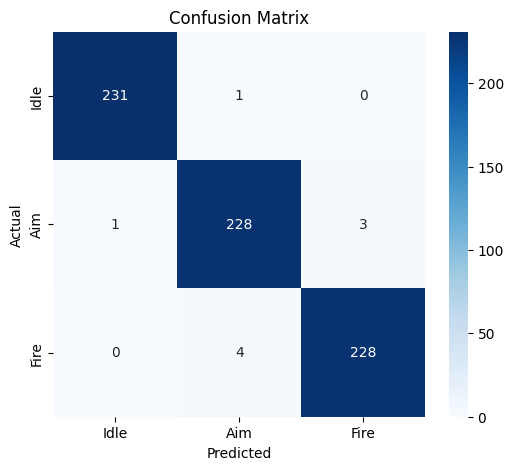

In [9]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y_batch.cpu().tolist())

from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1-Score
report = classification_report(all_labels, all_preds, target_names=["Idle", "Aim", "Fire"])
print(report)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming all_labels and all_preds are your lists of true/pred labels
cm = confusion_matrix(all_labels, all_preds)

# Class names in order of your label map
classes = ["Idle", "Aim", "Fire"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()